
[Language Identification dataset](https://www.kaggle.com/datasets/zarajamshaid/language-identification-datasst)

In [ ]:
import io
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
import stopwordsiso as stopwords_iso
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import transformers
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import os

nltk.download('punkt')
nltk.download('stopwords')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/GDrive/')

Mounted at /content/GDrive/


In [4]:
df = pd.read_csv('/content/GDrive/MyDrive/Language_Detection_dataset.csv')


In [5]:
df.head(10)

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
5,エノが行きがかりでバスに乗ってしまい、気分が悪くなった際に助けるが、今すぐバスを降りたいと運...,Japanese
6,tsutinalar i̇ngilizce tsuutina kanadada albert...,Turkish
7,müller mox figura centralis circulorum doctoru...,Latin
8,برقی بار electric charge تمام زیرجوہری ذرات کی...,Urdu
9,シャーリー・フィールドは、サン・ベルナルド・アベニュー沿い市民センターとrtマーティン高校に...,Japanese


In [ ]:
print('number of records of each class : ')
labels = df['language'].unique()

for label in labels:
    print(label, ':', df['language'].value_counts()[f'{label}'])

number of records of each class : 
Estonian : 1000
Swedish : 1000
Thai : 1000
Tamil : 1000
Dutch : 1000
Japanese : 1000
Turkish : 1000
Latin : 1000
Urdu : 1000
Indonesian : 1000
Portugese : 1000
French : 1000
Chinese : 1000
Korean : 1000
Hindi : 1000
Spanish : 1000
Pushto : 1000
Persian : 1000
Romanian : 1000
Russian : 1000
English : 1000
Arabic : 1000


# Preprocessing

In [ ]:
iso_st = {}
for lang in stopwords_iso.langs():
    iso_st[lang] = len(stopwords_iso.stopwords(lang))

print('List of languages and their stopword counts supported by stopwordsiso : ')
for lang, count in iso_st.items():
    print(f"{lang} : {count}")



List of languages and their stopword counts supported by stopwordsiso : 
de : 620
fr : 691
hi : 225
hr : 179
es : 732
gu : 224
vi : 645
fa : 799
it : 632
gl : 160
bg : 259
ar : 480
pl : 329
zh : 794
ga : 109
ro : 434
zu : 29
eo : 173
ko : 679
eu : 98
la : 49
sk : 418
af : 51
no : 221
ur : 517
tl : 147
ja : 134
el : 847
sl : 446
hu : 789
lt : 474
en : 1298
he : 194
lv : 161
sw : 74
yo : 60
st : 31
mr : 99
tr : 504
ru : 559
sv : 418
da : 170
cs : 423
ha : 39
br : 1203
id : 758
uk : 73
th : 116
ca : 278
so : 30
nl : 413
fi : 847
et : 35
pt : 560
ms : 475
ku : 62
hy : 45
bn : 398


[check language code ](https://github.com/stopwords-iso/stopwords-iso)

In [ ]:
nltk_st = {}
for lang in stopwords.fileids():
    nltk_st[lang] = len(stopwords.words(lang))

print('List of languages and their stopword counts supported by nltk.corpus : ')
for lang, count in nltk_st.items():
    print(f"{lang} : {count}")



List of languages and their stopword counts supported by nltk.corpus : 
arabic : 754
azerbaijani : 165
basque : 326
bengali : 398
catalan : 278
chinese : 841
danish : 94
dutch : 101
english : 179
finnish : 235
french : 157
german : 232
greek : 265
hebrew : 221
hinglish : 1036
hungarian : 199
indonesian : 758
italian : 279
kazakh : 324
nepali : 255
norwegian : 176
portuguese : 207
romanian : 356
russian : 151
slovene : 1784
spanish : 313
swedish : 114
tajik : 163
turkish : 53


In [ ]:
# stop words list for 22 languages

stopword_lists = {
    'Estonian': set(stopwords_iso.stopwords("et")) if stopwords_iso.has_lang("et") else set(),
    'Swedish': set(stopwords.words('swedish')) if 'swedish' in stopwords.fileids() else set(),
    'Thai': set(stopwords_iso.stopwords("th")) if stopwords_iso.has_lang("th") else set(),
    'Tamil': set(stopwords_iso.stopwords("ta")) if stopwords_iso.has_lang("ta") else set(),
    'Dutch': set(stopwords_iso.stopwords("nl")) if stopwords_iso.has_lang("nl") else set(),
    'Japanese': set(stopwords_iso.stopwords("ja")) if stopwords_iso.has_lang("ja") else set(),
    'Turkish': set(stopwords_iso.stopwords("tr")) if stopwords_iso.has_lang("tr") else set(),
    'Latin': set(stopwords_iso.stopwords("la")) if stopwords_iso.has_lang("la") else set(),
    'Urdu': set(stopwords_iso.stopwords("ur")) if stopwords_iso.has_lang("ur") else set(),
    'Indonesian': set(stopwords.words('indonesian')) if 'indonesian' in stopwords.fileids() else set(),
    'Portuguese': set(stopwords_iso.stopwords("pt")) if stopwords_iso.has_lang("pt") else set(),
    'French': set(stopwords_iso.stopwords("fr")) if stopwords_iso.has_lang("fr") else set(),
    'Chinese': set(stopwords_iso.stopwords("zh")) if stopwords_iso.has_lang("zh") else set(),
    'Korean': set(stopwords_iso.stopwords("ko")) if stopwords_iso.has_lang("ko") else set(),
    'Hindi': set(stopwords_iso.stopwords("hi")) if stopwords_iso.has_lang("hi") else set(),
    'Spanish': set(stopwords_iso.stopwords("es")) if stopwords_iso.has_lang("es") else set(),
    'Pushto': set(stopwords_iso.stopwords("ps")) if stopwords_iso.has_lang("ps") else set(),
    'Persian': set(stopwords_iso.stopwords("fa")) if stopwords_iso.has_lang("fa") else set(),
    'Romanian': set(stopwords.words('romanian')) if 'romanian' in stopwords.fileids() else set(),
    'Russian': set(stopwords_iso.stopwords("ru")) if stopwords_iso.has_lang("ru") else set(),
    'English': set(stopwords_iso.stopwords("en")) if stopwords_iso.has_lang("en") else set(),
    'Arabic': set(stopwords.words('arabic')) if 'arabic' in stopwords.fileids() else set(),
}

In [ ]:
# check if stopwords for each language are available
print("number of stopwords loaded for each language:")
for language, stop_words in stopword_lists.items():
    print(f"{language}: {len(stop_words)} stopwords")

number of stopwords loaded for each language:
Estonian: 35 stopwords
Swedish: 114 stopwords
Thai: 116 stopwords
Tamil: 0 stopwords
Dutch: 413 stopwords
Japanese: 134 stopwords
Turkish: 504 stopwords
Latin: 49 stopwords
Urdu: 517 stopwords
Indonesian: 757 stopwords
Portuguese: 560 stopwords
French: 691 stopwords
Chinese: 794 stopwords
Korean: 679 stopwords
Hindi: 225 stopwords
Spanish: 732 stopwords
Pushto: 0 stopwords
Persian: 799 stopwords
Romanian: 356 stopwords
Russian: 559 stopwords
English: 1298 stopwords
Arabic: 701 stopwords


so Tamil and Pushto are not suppoerted with both libraries

In [ ]:
def preprocessing_text(text, language_name):

    #lowercase characters
    text = text.lower()

    # remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    #remove numbers
    text = re.sub(r'\d+', '', text)

    # remove leading and trailing spaces
    text = text.strip()

    # removing extra spaces and tabs
    text = ' '.join(text.split())

    # deleting stop words
    stopwords_set = stopword_lists.get(language_name, set())
    text = ' '.join([word for word in text.split() if word not in stopwords_set])

    return text

# TF_IDF method


In [ ]:

models = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "linear_svm" : SVC(kernel='linear'),
    "guassian_svm" : SVC(kernel='rbf', gamma=0.1)

}

### predicting labes with preprocessing

In [ ]:
p_df = pd.DataFrame()

# preprocessing data

p_df['Text'] = df.apply(lambda row: preprocessing_text(row['Text'], row['language']), axis=1)
p_df['language'] = df['language']

In [ ]:
print("original dataframe :")
df.head(10)

original dataframe :


,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
5,エノが行きがかりでバスに乗ってしまい、気分が悪くなった際に助けるが、今すぐバスを降りたいと運...,Japanese
6,tsutinalar i̇ngilizce tsuutina kanadada albert...,Turkish
7,müller mox figura centralis circulorum doctoru...,Latin
8,برقی بار electric charge تمام زیرجوہری ذرات کی...,Urdu
9,シャーリー・フィールドは、サン・ベルナルド・アベニュー沿い市民センターとrtマーティン高校に...,Japanese


In [ ]:
print("dataframe after preprocessing :")
p_df.head(10)

dataframe after preprocessing :


,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas eng the jesuits an...,Swedish
2,ถนนเจรญกรง อกษรโรมน thanon charoen krung เรมตง...,Thai
3,வசகபபடடனம தமழசசஙகதத இநதப பததரகவசகபபடடன ஆசரயர ச...,Tamil
4,spons behoort geslacht haliclona behoort famil...,Dutch
5,エノが行きがかりでバスに乗ってしまい気分が悪くなった際に助けるが今すぐバスを降りたいと運転手...,Japanese
6,tsutinalar ingilizce tsuutina kanadada alberta...,Turkish
7,müller mox figura centralis circulorum doctoru...,Latin
8,برقی بار electric charge تمام زیرجوہری ذرات ا ...,Urdu
9,シャーリーフィールドはサンベルナルドアベニュー沿い市民センターとrtマーティン高校に隣接して...,Japanese


In [ ]:
X = p_df['Text']
y = p_df['language']
labels = y.unique()

Model: Naive Bayes
[0.8488636363636364, 0.8493181818181819, 0.8859090909090909, 0.8434090909090909, 0.8443181818181819]
Mean Accuracy for Naive Bayes: 85.44
Fold 2 is closest to the mean accuracy.
Classification Report for Naive Bayes (Fold 2):
              precision    recall  f1-score   support

      Arabic       0.99      0.99      0.99       201
     Chinese       0.35      0.04      0.08       183
       Dutch       0.96      0.87      0.91       189
     English       0.84      0.96      0.89       203
    Estonian       0.97      0.91      0.94       207
      French       0.98      0.95      0.96       206
       Hindi       1.00      0.98      0.99       198
  Indonesian       0.23      0.96      0.38       168
    Japanese       0.50      0.00      0.01       209
      Korean       1.00      0.94      0.97       213
       Latin       0.96      0.96      0.96       205
     Persian       0.99      0.99      0.99       195
   Portugese       0.92      0.99      0.96       19

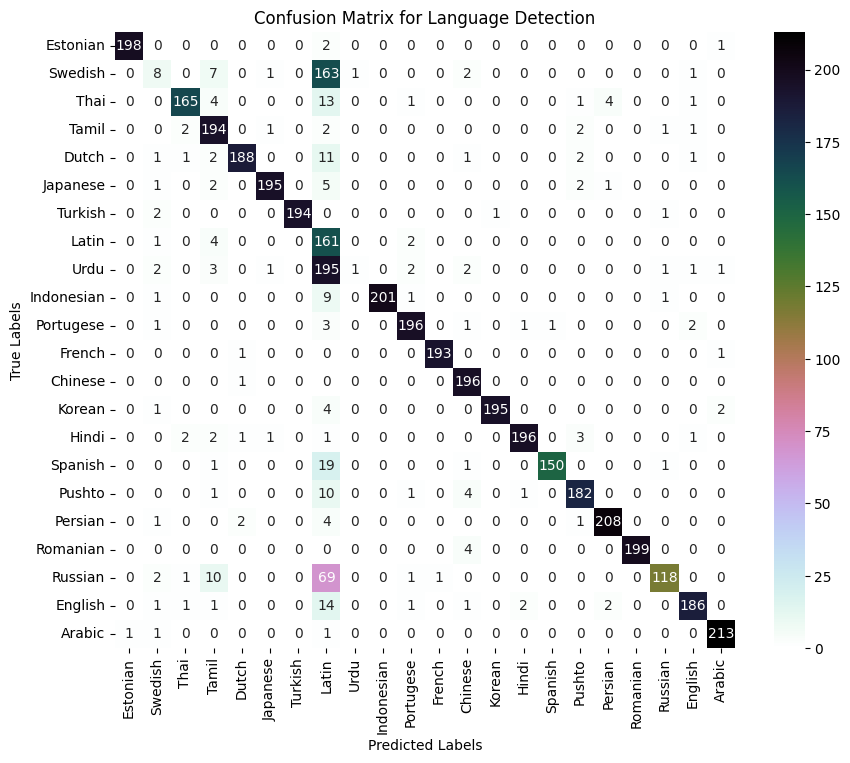


 ------------------------------------------------------------
Model: Random Forest
[0.8618181818181818, 0.8627272727272727, 0.8615909090909091, 0.8620454545454546, 0.8640909090909091]
Mean Accuracy for Random Forest: 86.25
Fold 2 is closest to the mean accuracy.
Classification Report for Random Forest (Fold 2):
              precision    recall  f1-score   support

      Arabic       0.98      0.94      0.96       201
     Chinese       0.18      0.03      0.05       183
       Dutch       0.90      0.82      0.86       189
     English       0.82      0.89      0.85       203
    Estonian       0.97      0.88      0.92       207
      French       0.96      0.87      0.91       206
       Hindi       1.00      0.97      0.99       198
  Indonesian       0.97      0.87      0.92       168
    Japanese       0.32      0.94      0.47       209
      Korean       0.99      0.92      0.95       213
       Latin       0.95      0.88      0.91       205
     Persian       0.98      0.95    

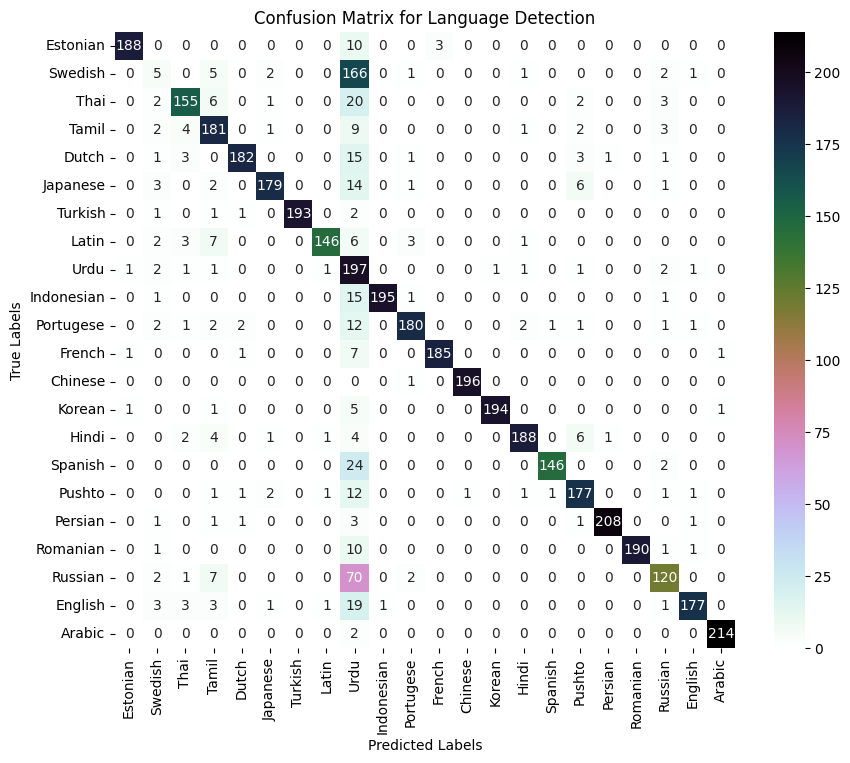


 ------------------------------------------------------------
Model: Logistic Regression
[0.8834090909090909, 0.8845454545454545, 0.8775, 0.8822727272727273, 0.8852272727272728]
Mean Accuracy for Logistic Regression: 88.26
Fold 4 is closest to the mean accuracy.
Classification Report for Logistic Regression (Fold 4):
              precision    recall  f1-score   support

      Arabic       0.99      0.97      0.98       198
     Chinese       0.31      0.06      0.09       197
       Dutch       0.96      0.89      0.92       189
     English       0.87      0.96      0.91       198
    Estonian       0.95      0.88      0.92       188
      French       0.97      0.93      0.95       206
       Hindi       1.00      0.98      0.99       213
  Indonesian       0.97      0.96      0.97       189
    Japanese       0.35      0.92      0.50       220
      Korean       1.00      0.92      0.96       188
       Latin       0.91      0.90      0.91       202
     Persian       1.00      0.

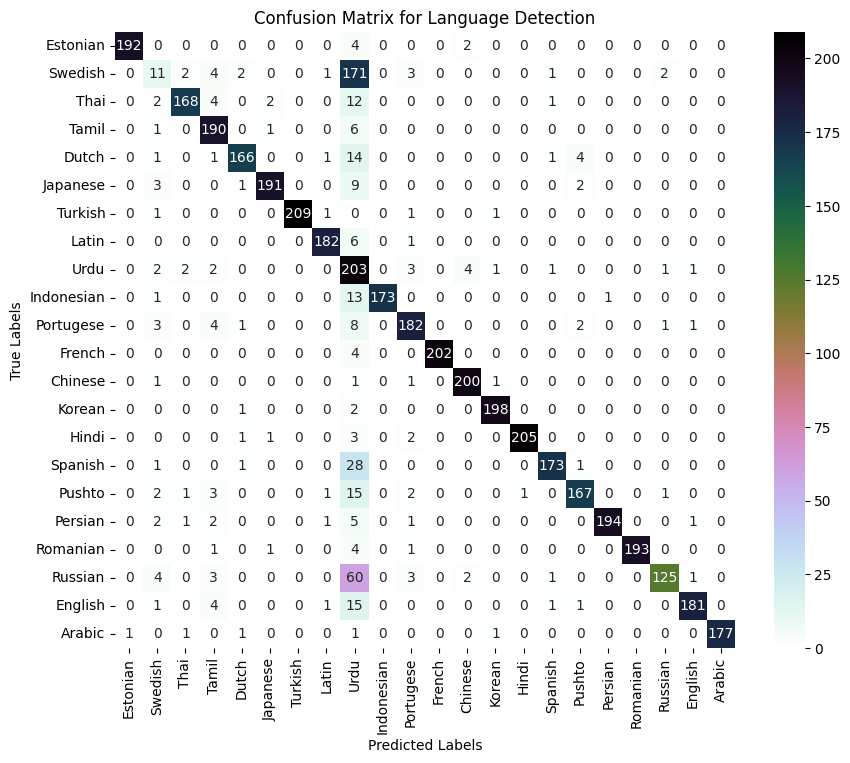


 ------------------------------------------------------------
Model: linear_svm
[0.8652272727272727, 0.8709090909090909, 0.8665909090909091, 0.8729545454545454, 0.8681818181818182]
Mean Accuracy for linear_svm: 86.88
Fold 5 is closest to the mean accuracy.
Classification Report for linear_svm (Fold 5):
              precision    recall  f1-score   support

      Arabic       1.00      0.94      0.97       216
     Chinese       0.24      0.06      0.09       210
       Dutch       0.97      0.89      0.93       202
     English       0.90      0.92      0.91       203
    Estonian       0.97      0.85      0.90       196
      French       0.98      0.88      0.93       221
       Hindi       0.99      0.95      0.97       196
  Indonesian       0.98      0.92      0.95       213
    Japanese       0.30      0.95      0.46       206
      Korean       1.00      0.93      0.97       213
       Latin       0.87      0.90      0.88       187
     Persian       0.99      0.98      0.99   

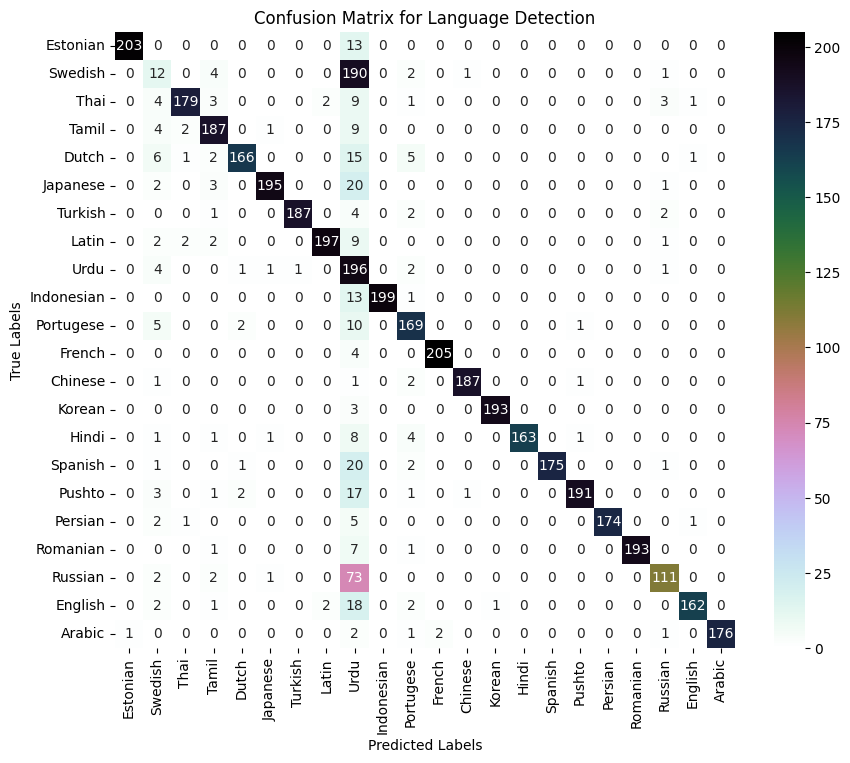


 ------------------------------------------------------------
Model: guassian_svm
[0.8795454545454545, 0.8743181818181818, 0.8736363636363637, 0.8704545454545455, 0.8768181818181818]
Mean Accuracy for guassian_svm: 87.50
Fold 2 is closest to the mean accuracy.
Classification Report for guassian_svm (Fold 2):
              precision    recall  f1-score   support

      Arabic       0.99      0.99      0.99       201
     Chinese       0.32      0.91      0.47       183
       Dutch       0.95      0.86      0.90       189
     English       0.78      0.97      0.87       203
    Estonian       0.99      0.88      0.93       207
      French       0.97      0.94      0.96       206
       Hindi       1.00      0.97      0.99       198
  Indonesian       0.95      0.95      0.95       168
    Japanese       1.00      0.00      0.00       209
      Korean       1.00      0.92      0.96       213
       Latin       0.85      0.93      0.89       205
     Persian       0.99      0.98      0

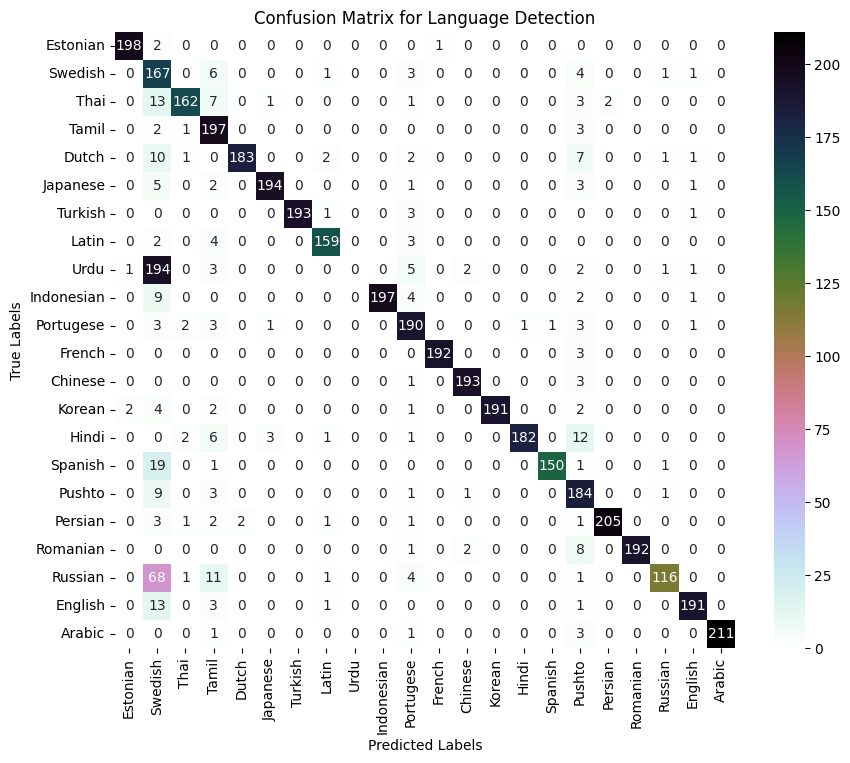


 ------------------------------------------------------------


In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"Model: {model_name}")

    fold_accuracies = []
    fold_confusion_matrices = []
    fold_classification_report = []

    # start Cross-Validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):

        # spliting data
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf, y_test_kf = y[train_index], y[test_index]
        # converting text to vector
        tfidf_kf = TfidfVectorizer(max_features=5000) # automatically
        X_train_tdidf_kf = tfidf_kf.fit_transform(X_train_kf)
        X_test_tdidf_kf = tfidf_kf.transform(X_test_kf)

        # training model
        model.fit(X_train_tdidf_kf, y_train_kf)

        # predicting
        y_pred = model.predict(X_test_tdidf_kf)

        # calc accuracy
        accuracy = accuracy_score(y_test_kf, y_pred)
        fold_accuracies.append(accuracy)

        # calc confusion matrix
        conf_matrix = confusion_matrix(y_test_kf, y_pred)
        fold_confusion_matrices.append(conf_matrix)

        cl_report = classification_report(y_test_kf, y_pred, zero_division=1)
        fold_classification_report.append(cl_report)

    # calc mean of accuracies of 5 fold
    print(fold_accuracies)
    mean_accuracy = np.mean(fold_accuracies)
    print(f"Mean Accuracy for {model_name}: {mean_accuracy * 100:.2f}")

    #find the closest fold to mean of accuracies
    closest_fold = np.argmin(np.abs(np.array(fold_accuracies) - mean_accuracy))
    print(f"Fold {closest_fold+1} is closest to the mean accuracy.")

    closest_cl_report= fold_classification_report[closest_fold]
    print(f"Classification Report for {model_name} (Fold {closest_fold+1}):\n{closest_cl_report}")

    #show confusion matrix for that fold
    closest_conf_matrix = fold_confusion_matrices[closest_fold]
    print(f"Confusion Matrix for {model_name} (Fold {closest_fold+1}):")

    plt.figure(figsize=(10, 8))
    sns.heatmap(closest_conf_matrix, annot=True, fmt='d', cmap='cubehelix_r', xticklabels=labels , yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Language Detection')
    plt.show()
    print("\n","-"*60)

### predicting labels without preproccessing

Model: Naive Bayes
[0.9131818181818182, 0.9118181818181819, 0.9379545454545455, 0.9084090909090909, 0.9086363636363637]
Mean Accuracy for Naive Bayes: 91.60
Fold 1 is closest to the mean accuracy.
Classification Report for Naive Bayes (Fold 1):
              precision    recall  f1-score   support

      Arabic       1.00      0.99      1.00       202
     Chinese       0.81      0.23      0.36       201
       Dutch       0.99      0.98      0.98       230
     English       0.72      1.00      0.84       194
    Estonian       0.98      0.94      0.96       200
      French       0.93      0.98      0.96       188
       Hindi       1.00      0.99      0.99       208
  Indonesian       1.00      0.98      0.99       213
    Japanese       0.98      0.30      0.46       194
      Korean       1.00      0.98      0.99       190
       Latin       0.98      0.90      0.94       210
     Persian       0.99      0.99      0.99       196
   Portugese       0.99      0.96      0.98       19

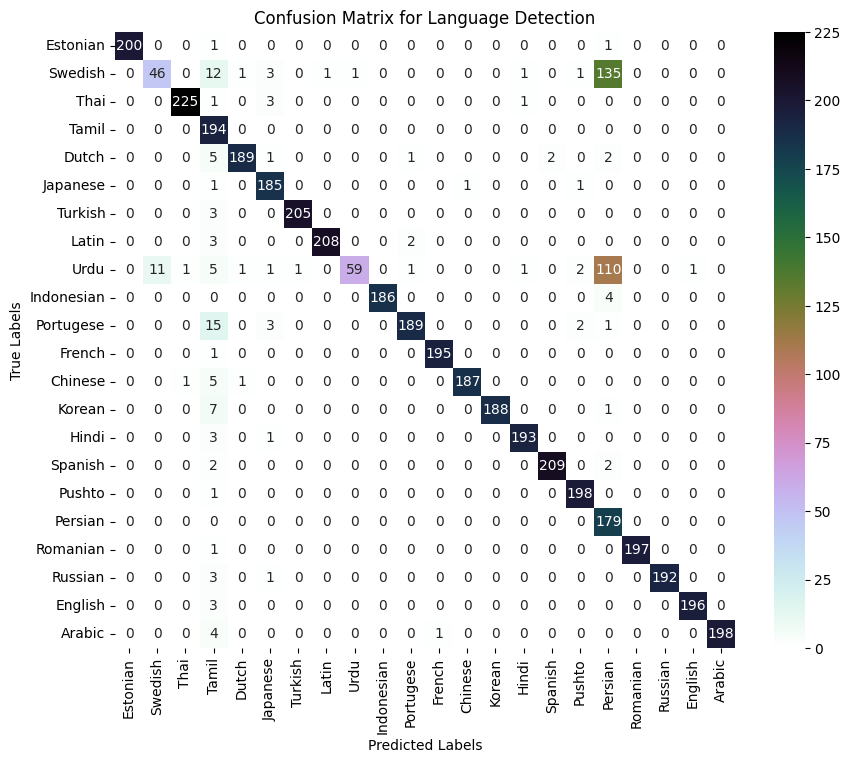


 ------------------------------------------------------------
Model: Random Forest
[0.9456818181818182, 0.9440909090909091, 0.9470454545454545, 0.9347727272727273, 0.9429545454545455]
Mean Accuracy for Random Forest: 94.29
Fold 5 is closest to the mean accuracy.
Classification Report for Random Forest (Fold 5):
              precision    recall  f1-score   support

      Arabic       1.00      0.99      0.99       216
     Chinese       0.54      0.97      0.69       210
       Dutch       0.99      0.99      0.99       202
     English       0.84      0.99      0.91       203
    Estonian       0.98      0.93      0.96       196
      French       0.98      1.00      0.99       221
       Hindi       1.00      0.97      0.98       196
  Indonesian       0.99      1.00      0.99       213
    Japanese       0.91      0.36      0.52       206
      Korean       1.00      0.94      0.97       213
       Latin       0.93      0.99      0.96       187
     Persian       1.00      0.98    

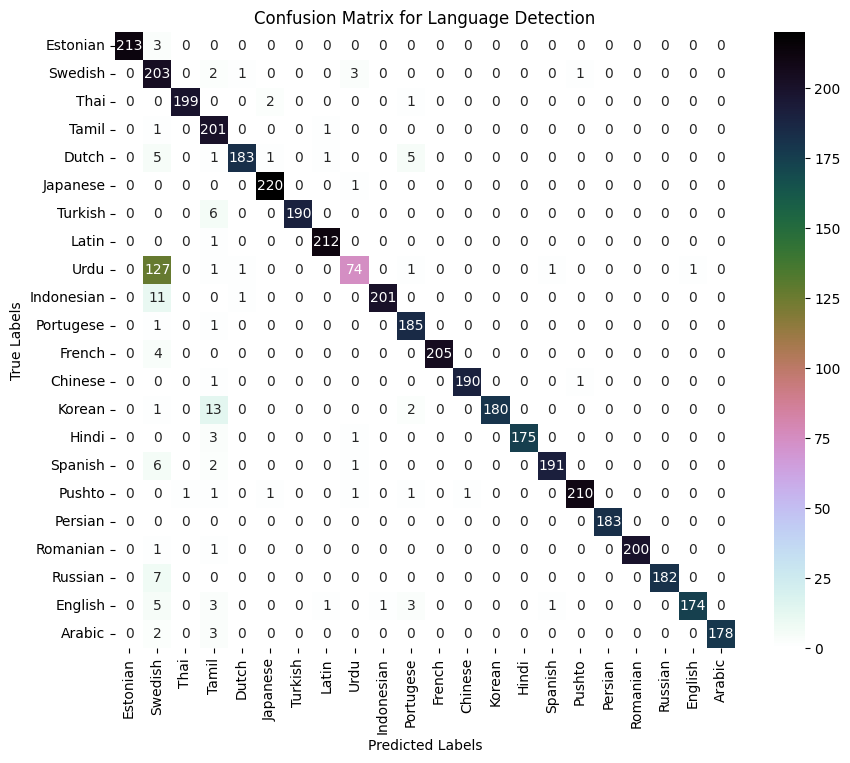


 ------------------------------------------------------------
Model: Logistic Regression
[0.945, 0.9429545454545455, 0.9411363636363637, 0.9340909090909091, 0.9386363636363636]
Mean Accuracy for Logistic Regression: 94.04
Fold 3 is closest to the mean accuracy.
Classification Report for Logistic Regression (Fold 3):
              precision    recall  f1-score   support

      Arabic       0.99      0.96      0.97       183
     Chinese       0.54      0.94      0.69       209
       Dutch       1.00      0.97      0.99       190
     English       0.83      0.99      0.90       202
    Estonian       1.00      0.95      0.98       209
      French       0.94      0.99      0.97       179
       Hindi       1.00      0.98      0.99       185
  Indonesian       1.00      0.96      0.98       217
    Japanese       0.65      0.30      0.41       171
      Korean       1.00      0.97      0.99       196
       Latin       0.96      0.91      0.93       196
     Persian       0.99      0.9

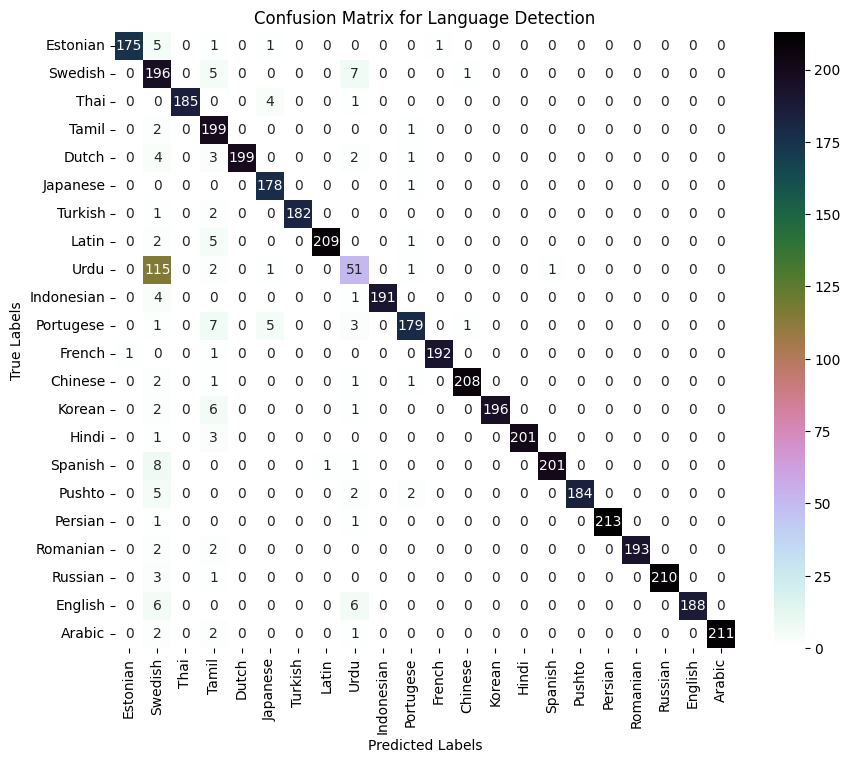


 ------------------------------------------------------------
Model: linear_svm
[0.9431818181818182, 0.9418181818181818, 0.9436363636363636, 0.9356818181818182, 0.9388636363636363]
Mean Accuracy for linear_svm: 94.06
Fold 2 is closest to the mean accuracy.
Classification Report for linear_svm (Fold 2):
              precision    recall  f1-score   support

      Arabic       0.99      0.99      0.99       201
     Chinese       0.47      0.96      0.63       183
       Dutch       1.00      0.99      1.00       189
     English       0.86      0.98      0.92       203
    Estonian       0.99      0.98      0.98       207
      French       0.99      0.99      0.99       206
       Hindi       1.00      0.97      0.98       198
  Indonesian       0.99      0.96      0.98       168
    Japanese       0.97      0.32      0.48       209
      Korean       1.00      0.93      0.96       213
       Latin       0.95      0.94      0.95       205
     Persian       0.99      0.99      0.99   

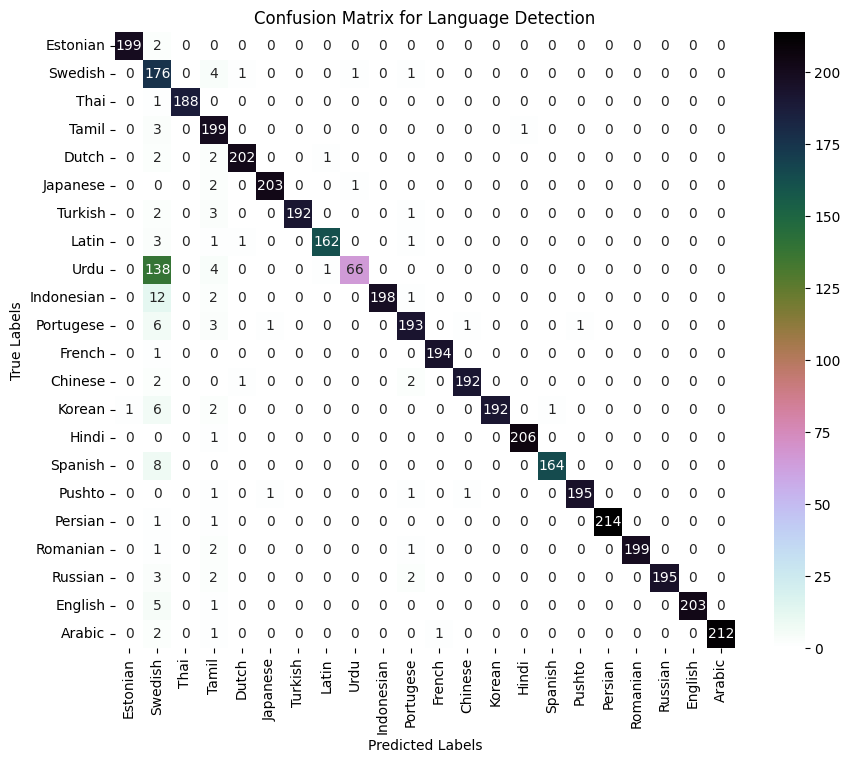


 ------------------------------------------------------------
Model: guassian_svm
[0.9434090909090909, 0.9434090909090909, 0.9436363636363636, 0.9345454545454546, 0.9372727272727273]
Mean Accuracy for guassian_svm: 94.05
Fold 1 is closest to the mean accuracy.
Classification Report for guassian_svm (Fold 1):
              precision    recall  f1-score   support

      Arabic       1.00      0.99      0.99       202
     Chinese       0.53      0.96      0.69       201
       Dutch       1.00      0.97      0.98       230
     English       0.79      0.98      0.88       194
    Estonian       0.99      0.94      0.97       200
      French       0.94      0.98      0.96       188
       Hindi       1.00      0.99      0.99       208
  Indonesian       1.00      0.98      0.99       213
    Japanese       1.00      0.30      0.46       194
      Korean       0.99      0.98      0.99       190
       Latin       0.97      0.92      0.94       210
     Persian       1.00      0.99      0

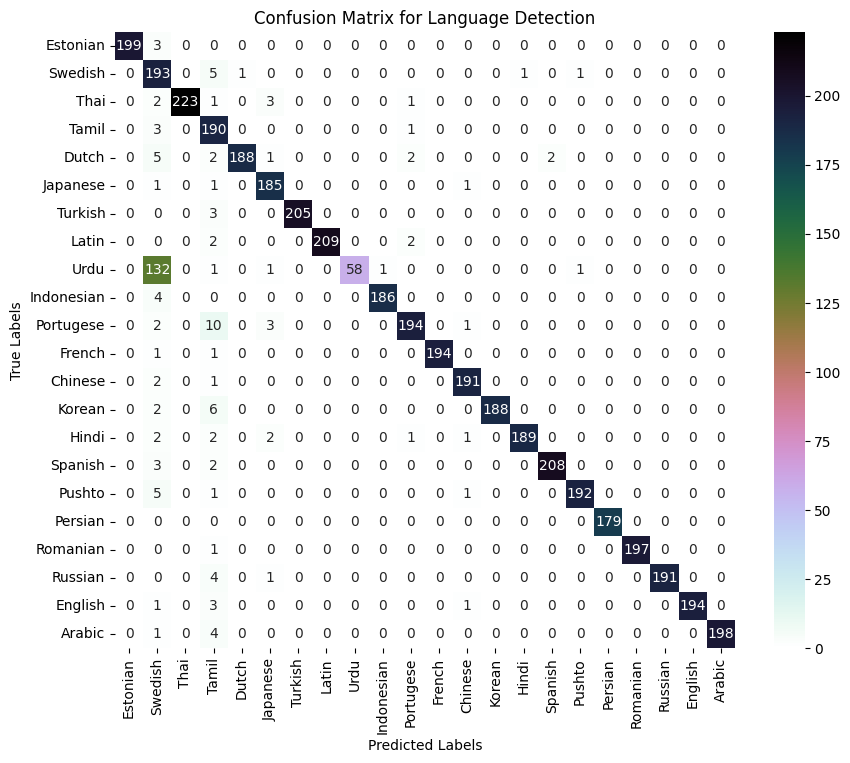


 ------------------------------------------------------------


In [ ]:

X_w = df['Text']
y_w = df['language']


kf_w = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"Model: {model_name}")

    fold_accuracies = []
    fold_confusion_matrices = []
    fold_classification_report = []

    # start Cross-Validation
    for fold, (train_index, test_index) in enumerate(kf_w.split(X_w)):

        # spliting data
        X_train_kf, X_test_kf = X_w.iloc[train_index], X_w.iloc[test_index]
        y_train_kf, y_test_kf = y_w[train_index], y_w[test_index]
        # converting text to vector
        tfidf_kf = TfidfVectorizer(max_features=5000)
        X_train_tdidf_kf = tfidf_kf.fit_transform(X_train_kf)
        X_test_tdidf_kf = tfidf_kf.transform(X_test_kf)

        # training model
        model.fit(X_train_tdidf_kf, y_train_kf)

        # predicting
        y_pred = model.predict(X_test_tdidf_kf)

        # calc accuracy
        accuracy = accuracy_score(y_test_kf, y_pred)
        fold_accuracies.append(accuracy)

        # calc confusion matrix
        conf_matrix = confusion_matrix(y_test_kf, y_pred)
        fold_confusion_matrices.append(conf_matrix)

        cl_report = classification_report(y_test_kf, y_pred, zero_division=1)
        fold_classification_report.append(cl_report)

    # calc mean of accuracies of 5 fold
    print(fold_accuracies)
    mean_accuracy = np.mean(fold_accuracies)
    print(f"Mean Accuracy for {model_name}: {mean_accuracy * 100:.2f}")

    #find the closest fold to mean of accuracies
    closest_fold = np.argmin(np.abs(np.array(fold_accuracies) - mean_accuracy))
    print(f"Fold {closest_fold+1} is closest to the mean accuracy.")

    closest_cl_report= fold_classification_report[closest_fold]
    print(f"Classification Report for {model_name} (Fold {closest_fold+1}):\n{closest_cl_report}")

    #show confusion matrix for that fold
    closest_conf_matrix = fold_confusion_matrices[closest_fold]
    print(f"Confusion Matrix for {model_name} (Fold {closest_fold+1}):")

    plt.figure(figsize=(10, 8))
    sns.heatmap(closest_conf_matrix, annot=True, fmt='d', cmap='cubehelix_r', xticklabels=labels , yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Language Detection')
    plt.show()
    print("\n","-"*60)

## compare tf-idf method with preprocessing and without preprocessing :

model name  |  with preprocessing  |  without preprocessing
------------|----------------------|-----------------------
Naive Bayes |  85.44               |  91.60   
Random Forest | 86.25              |  94.29
Logistic Regression | 88.26        |  94.04
Linear SVM | 86.88                 |  94.06
Gaussian SVM | 87.50               |  94.05



# word2vec method


In [ ]:
# models
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "linear_svm" : SVC(kernel='linear'),
    "gaussian_svm" : SVC(kernel='rbf', gamma=0.1)
}

### predicting labes with preproccessing

In [ ]:
data = pd.DataFrame()

# preproccessing texts
data['tokens'] = df.apply(lambda row: preprocessing_text(row['Text'], row['language']), axis=1)


data['language'] = df['language']

data['tokens'].head(10)

,tokens
0,klement gottwaldi surnukeha palsameeriti ning ...
1,sebes joseph pereira thomas eng the jesuits an...
2,ถนนเจรญกรง อกษรโรมน thanon charoen krung เรมตง...
3,வசகபபடடனம தமழசசஙகதத இநதப பததரகவசகபபடடன ஆசரயர ச...
4,spons behoort geslacht haliclona behoort famil...
5,エノが行きがかりでバスに乗ってしまい気分が悪くなった際に助けるが今すぐバスを降りたいと運転手...
6,tsutinalar ingilizce tsuutina kanadada alberta...
7,müller mox figura centralis circulorum doctoru...
8,برقی بار electric charge تمام زیرجوہری ذرات ا ...
9,シャーリーフィールドはサンベルナルドアベニュー沿い市民センターとrtマーティン高校に隣接して...


tokenizing text

In [ ]:
data['tokens'] = data['tokens'].apply(word_tokenize)

In [ ]:
data.head(10)

,tokens,language
0,"[klement, gottwaldi, surnukeha, palsameeriti, ...",Estonian
1,"[sebes, joseph, pereira, thomas, eng, the, jes...",Swedish
2,"[ถนนเจรญกรง, อกษรโรมน, thanon, charoen, krung,...",Thai
3,"[வசகபபடடனம, தமழசசஙகதத, இநதப, பததரகவசகபபடடன, ஆச...",Tamil
4,"[spons, behoort, geslacht, haliclona, behoort,...",Dutch
5,[エノが行きがかりでバスに乗ってしまい気分が悪くなった際に助けるが今すぐバスを降りたいと運転...,Japanese
6,"[tsutinalar, ingilizce, tsuutina, kanadada, al...",Turkish
7,"[müller, mox, figura, centralis, circulorum, d...",Latin
8,"[برقی, بار, electric, charge, تمام, زیرجوہری, ...",Urdu
9,[シャーリーフィールドはサンベルナルドアベニュー沿い市民センターとrtマーティン高校に隣接し...,Japanese


In [ ]:
# convert each word(token) to a vector
def get_sentence_vector(model, tokens, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count > 0:
        vec /= count
    return vec

# testing the function
print('text without preprocessing and tokenization : ')
print(df.iloc[37,0])
print(f'text length : {len(df.iloc[37,0])}')
print('-'*50)
# show preproccessed text
print('text after preprocessing and tokenization : ')
print(data.iloc[37,0])
# show number of words of the text
print(f'text length : {len(data.iloc[37,0])}')
print('-'*50)

# set parameters
vector_size = 100

model_w2v = Word2Vec(sentences=data.iloc[37, 0], vector_size=100, window=5, min_count=1, workers=4)

text = np.array([get_sentence_vector(model_w2v, tokens, vector_size) for tokens in data.iloc[37, 0]])
# show vector of words
print(text)
print(len(text))

text without preprocessing and tokenization : 
in  johnson was awarded an american institute of architects gold medal in  he became the first recipient of the pritzker architecture prize the most prestigious international architectural award
text length : 194
--------------------------------------------------
text after preprocessing and tokenization : 
['johnson', 'awarded', 'american', 'institute', 'architects', 'gold', 'medal', 'recipient', 'pritzker', 'architecture', 'prize', 'prestigious', 'international', 'architectural', 'award']
text length : 15
--------------------------------------------------
[[-3.52286122e-03  5.48461668e-04 -4.74739487e-04 ...  4.47029181e-04
   5.69272843e-03 -1.53713035e-03]
 [-2.04540837e-03  2.62881916e-04  2.30798953e-03 ...  5.17896510e-05
   1.15757164e-03  2.16536743e-03]
 [-3.81765098e-03  2.56806352e-03 -3.95423880e-04 ... -2.97893048e-03
  -5.86841008e-04  4.10302193e-04]
 ...
 [-5.62665911e-03  1.98228683e-03 -1.45486590e-03 ... -2.18239063e-03

Model: Random Forest
[0.6165909090909091, 0.6315909090909091, 0.6175, 0.6597727272727273, 0.6263636363636363]
Mean Accuracy for Random Forest: 63.04
Fold 2 is closest to the mean accuracy.
Classification Report for Random Forest (Fold 2):
              precision    recall  f1-score   support

      Arabic       0.78      0.81      0.79       201
     Chinese       0.24      0.03      0.06       183
       Dutch       0.14      0.37      0.21       189
     English       0.63      0.87      0.73       203
    Estonian       0.49      0.45      0.47       207
      French       0.36      0.47      0.41       206
       Hindi       0.96      0.98      0.97       198
  Indonesian       0.48      0.60      0.53       168
    Japanese       0.35      0.04      0.08       209
      Korean       0.67      0.58      0.62       213
       Latin       0.67      0.66      0.67       205
     Persian       0.87      0.94      0.90       195
   Portugese       0.97      0.96      0.97       197
    

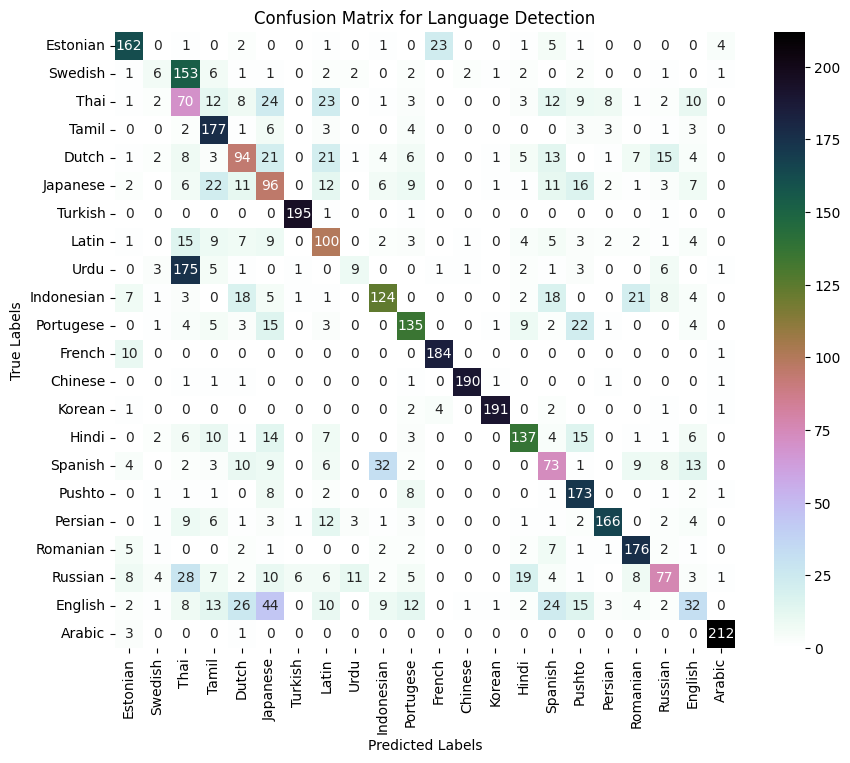


 ------------------------------------------------------------
Model: Logistic Regression
[0.4954545454545455, 0.5018181818181818, 0.4968181818181818, 0.5040909090909091, 0.48409090909090907]
Mean Accuracy for Logistic Regression: 49.65
Fold 3 is closest to the mean accuracy.
Classification Report for Logistic Regression (Fold 3):
              precision    recall  f1-score   support

      Arabic       0.72      0.75      0.74       183
     Chinese       0.18      0.01      0.03       209
       Dutch       0.59      0.24      0.34       190
     English       0.57      0.13      0.21       202
    Estonian       0.06      0.01      0.02       209
      French       0.23      0.22      0.22       179
       Hindi       0.96      0.98      0.97       185
  Indonesian       0.24      0.29      0.27       217
    Japanese       0.33      0.86      0.48       171
      Korean       0.17      0.27      0.21       196
       Latin       0.53      0.53      0.53       196
     Persian      

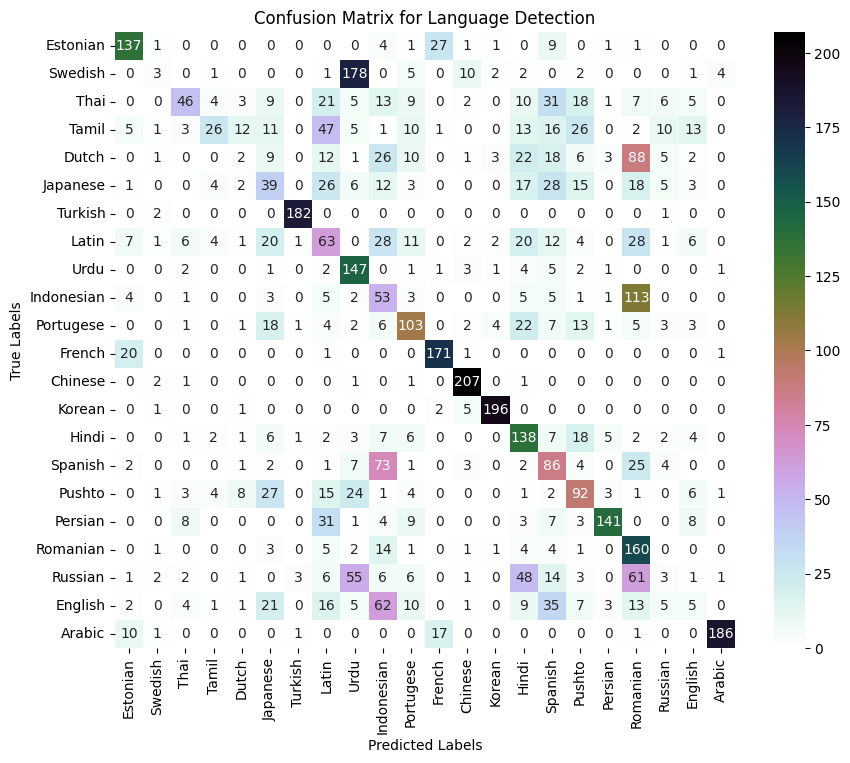


 ------------------------------------------------------------
Model: linear_svm
[0.5084090909090909, 0.5022727272727273, 0.4940909090909091, 0.5020454545454546, 0.49886363636363634]
Mean Accuracy for linear_svm: 50.11
Fold 4 is closest to the mean accuracy.
Classification Report for linear_svm (Fold 4):
              precision    recall  f1-score   support

      Arabic       0.82      0.66      0.73       198
     Chinese       0.37      0.87      0.52       197
       Dutch       0.57      0.15      0.24       189
     English       0.38      0.24      0.29       198
    Estonian       0.07      0.06      0.06       188
      French       0.25      0.06      0.10       206
       Hindi       1.00      0.98      0.99       213
  Indonesian       0.28      0.29      0.28       189
    Japanese       1.00      0.00      0.00       220
      Korean       0.18      0.33      0.23       188
       Latin       0.61      0.45      0.52       202
     Persian       0.85      0.90      0.88  

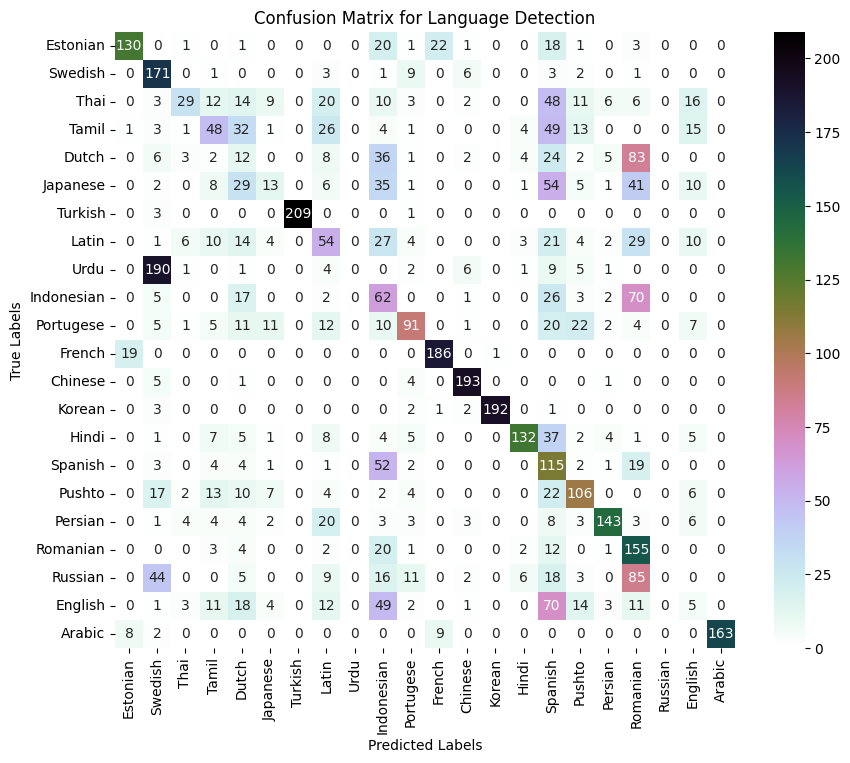


 ------------------------------------------------------------
Model: gaussian_svm
[0.4715909090909091, 0.4581818181818182, 0.45295454545454544, 0.4652272727272727, 0.4675]
Mean Accuracy for gaussian_svm: 46.31
Fold 4 is closest to the mean accuracy.
Classification Report for gaussian_svm (Fold 4):
              precision    recall  f1-score   support

      Arabic       0.74      0.39      0.51       198
     Chinese       0.36      0.87      0.51       197
       Dutch       0.57      0.13      0.21       189
     English       0.36      0.41      0.39       198
    Estonian       0.00      0.00      0.00       188
      French       0.21      0.06      0.09       206
       Hindi       0.98      0.98      0.98       213
  Indonesian       0.15      0.23      0.18       189
    Japanese       1.00      0.00      0.00       220
      Korean       0.12      0.30      0.17       188
       Latin       0.58      0.12      0.20       202
     Persian       0.83      0.88      0.85       2

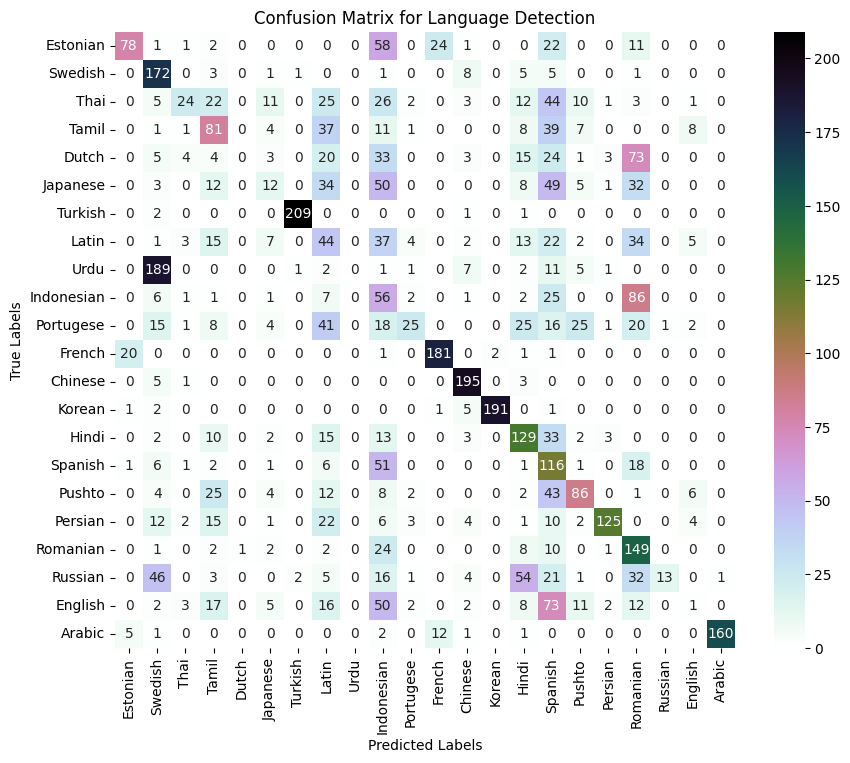


 ------------------------------------------------------------


In [ ]:

# k-fold cross validation splitting method
kf_w2v = KFold(n_splits=5, shuffle=True, random_state=42)


vector_size = 100


for model_name, model in models.items():
    print(f"Model: {model_name}")

    fold_accuracies_w2v = []
    fold_confusion_matrices_w2v = []
    fold_classification_report_w2v = []

    # start Cross-Validation
    for fold, (train_index, test_index) in enumerate(kf_w2v.split(data)):

        train_data_w2v = data.iloc[train_index]
        test_data_w2v = data.iloc[test_index]

        # training Word2Vec model on the training datas
        model_w2v = Word2Vec(sentences=train_data_w2v['tokens'], vector_size=100, window=5, min_count=1, workers=4)

        # convert training datas to vectors
        X_train_w2v = np.array([get_sentence_vector(model_w2v, tokens, vector_size) for tokens in train_data_w2v['tokens']])
        y_train_w2v = train_data_w2v['language']

        # convert test datas to vectors
        X_test_w2v = np.array([get_sentence_vector(model_w2v, tokens, vector_size) for tokens in test_data_w2v['tokens']])
        y_test_w2v = test_data_w2v['language']

        # training model
        model.fit(X_train_w2v, y_train_w2v)

        # predicting on test datas
        y_pred_w2v = model.predict(X_test_w2v)

        # calc accuracy
        accuracy_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
        fold_accuracies_w2v.append(accuracy_w2v)

        # calc confusion matrix
        conf_matrix_w2v = confusion_matrix(y_test_w2v, y_pred_w2v)
        fold_confusion_matrices_w2v.append(conf_matrix_w2v)

        cl_report_w2v = classification_report(y_test_w2v, y_pred_w2v, zero_division=1)
        fold_classification_report_w2v.append(cl_report_w2v)

    # calc mean of accuracies of 5 folds
    print(fold_accuracies_w2v)
    mean_accuracy_w2v = np.mean(fold_accuracies_w2v)
    print(f"Mean Accuracy for {model_name}: {mean_accuracy_w2v * 100:.2f}")

    # find the closest fold to the mean of accuracies
    closest_fold_w2v = np.argmin(np.abs(np.array(fold_accuracies_w2v) - mean_accuracy_w2v))
    print(f"Fold {closest_fold_w2v+1} is closest to the mean accuracy.")

    closest_cl_report_w2v= fold_classification_report_w2v[closest_fold_w2v]
    print(f"Classification Report for {model_name} (Fold {closest_fold_w2v+1}):\n{closest_cl_report_w2v}")

    # show confusion matrix for that fold
    closest_conf_matrix_w2v = fold_confusion_matrices_w2v[closest_fold_w2v]
    print(f"Confusion Matrix for {model_name} (Fold {closest_fold_w2v+1}):")

    plt.figure(figsize=(10, 8))
    sns.heatmap(closest_conf_matrix_w2v, annot=True, fmt='d', cmap='cubehelix_r', xticklabels=labels , yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Language Detection')
    plt.show()
    print("\n","-"*60)

### predicting labels without preproccessing

In [ ]:
data_tokenize = pd.DataFrame()
# tokenizing text
data_tokenize['tokens'] = df['Text'].apply(word_tokenize)
data_tokenize['language'] = df['language']

In [ ]:
data_tokenize.head(10)

,tokens,language
0,"[klement, gottwaldi, surnukeha, palsameeriti, ...",Estonian
1,"[sebes, joseph, pereira, thomas, på, eng, the,...",Swedish
2,"[ถนนเจริญกรุง, อักษรโรมัน, thanon, charoen, kr...",Thai
3,"[விசாகப்பட்டினம், தமிழ்ச்சங்கத்தை, இந்துப், பத...",Tamil
4,"[de, spons, behoort, tot, het, geslacht, halic...",Dutch
5,[エノが行きがかりでバスに乗ってしまい、気分が悪くなった際に助けるが、今すぐバスを降りたいと...,Japanese
6,"[tsutinalar, i̇ngilizce, tsuutina, kanadada, a...",Turkish
7,"[müller, mox, figura, centralis, circulorum, d...",Latin
8,"[برقی, بار, electric, charge, تمام, زیرجوہری, ...",Urdu
9,[シャーリー・フィールドは、サン・ベルナルド・アベニュー沿い市民センターとrtマーティン高校...,Japanese


Model: Random Forest
[0.8672727272727273, 0.8718181818181818, 0.8722727272727273, 0.9011363636363636, 0.8668181818181818]
Mean Accuracy for Random Forest: 0.8759
Fold 3 is closest to the mean accuracy.
Classification Report for Random Forest (Fold 3):
              precision    recall  f1-score   support

      Arabic       0.99      0.97      0.98       183
     Chinese       0.80      0.26      0.40       209
       Dutch       0.39      0.99      0.56       190
     English       0.78      0.99      0.87       202
    Estonian       0.94      0.93      0.93       209
      French       0.95      0.99      0.97       179
       Hindi       0.98      0.99      0.98       185
  Indonesian       1.00      0.96      0.98       217
    Japanese       0.23      0.05      0.08       171
      Korean       0.88      0.91      0.90       196
       Latin       0.88      0.88      0.88       196
     Persian       0.99      0.98      0.99       194
   Portugese       0.98      0.98      0.98  

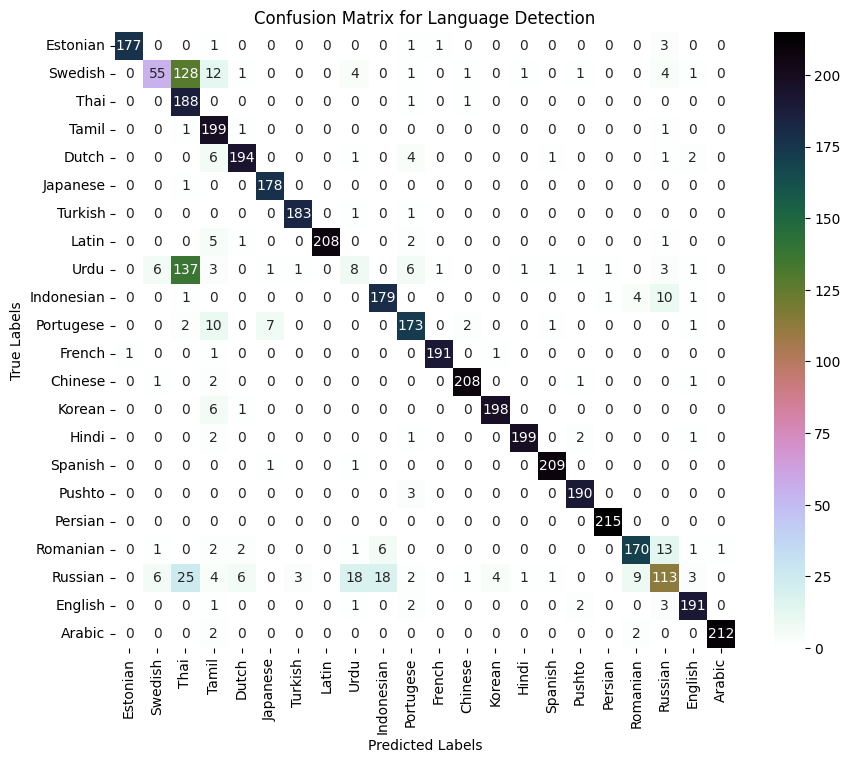

Model: Logistic Regression
[0.8888636363636364, 0.8968181818181818, 0.8863636363636364, 0.8865909090909091, 0.8956818181818181]
Mean Accuracy for Logistic Regression: 0.8909
Fold 1 is closest to the mean accuracy.
Classification Report for Logistic Regression (Fold 1):
              precision    recall  f1-score   support

      Arabic       0.99      0.99      0.99       202
     Chinese       0.81      0.23      0.36       201
       Dutch       0.93      0.99      0.96       230
     English       0.83      0.95      0.89       194
    Estonian       0.97      0.93      0.95       200
      French       0.95      0.95      0.95       188
       Hindi       0.94      0.99      0.96       208
  Indonesian       0.99      0.98      0.99       213
    Japanese       0.45      0.81      0.58       194
      Korean       0.83      0.92      0.87       190
       Latin       0.92      0.87      0.89       210
     Persian       0.99      0.99      0.99       196
   Portugese       0.92    

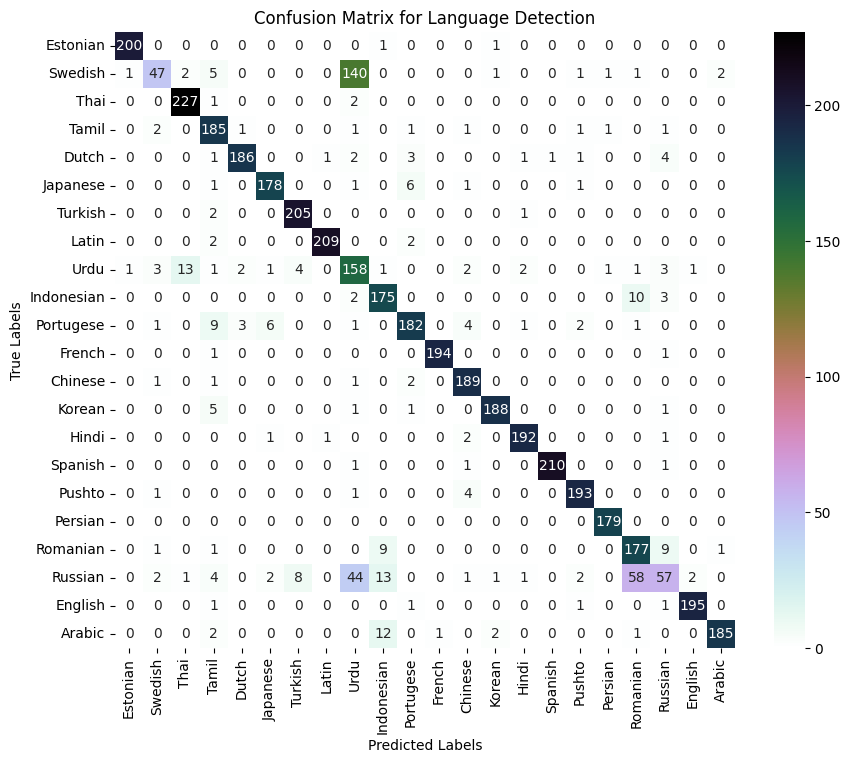

Model: linear_svm
[0.9011363636363636, 0.9034090909090909, 0.8968181818181818, 0.8947727272727273, 0.8922727272727272]
Mean Accuracy for linear_svm: 0.8977
Fold 3 is closest to the mean accuracy.
Classification Report for linear_svm (Fold 3):
              precision    recall  f1-score   support

      Arabic       0.99      0.96      0.98       183
     Chinese       0.89      0.24      0.38       209
       Dutch       0.98      0.99      0.98       190
     English       0.78      0.99      0.87       202
    Estonian       0.95      0.93      0.94       209
      French       0.96      0.99      0.97       179
       Hindi       1.00      0.98      0.99       185
  Indonesian       1.00      0.96      0.98       217
    Japanese       0.44      0.88      0.59       171
      Korean       0.82      0.91      0.86       196
       Latin       0.92      0.90      0.91       196
     Persian       0.99      0.99      0.99       194
   Portugese       0.97      0.98      0.97       213


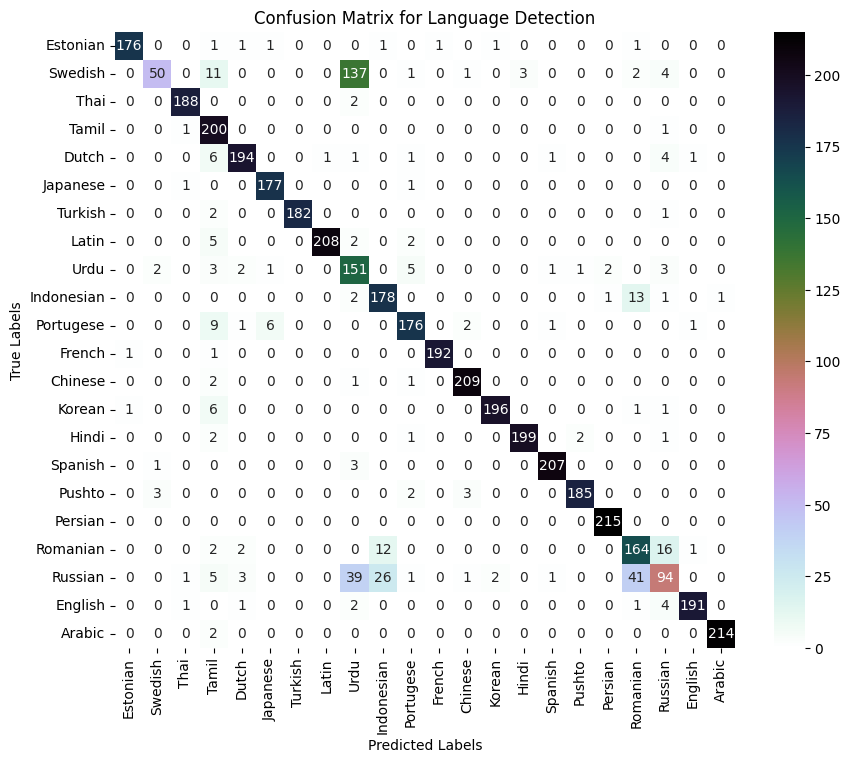

Model: gaussian_svm
[0.8645454545454545, 0.8854545454545455, 0.8577272727272728, 0.8679545454545454, 0.86]
Mean Accuracy for gaussian_svm: 0.8671
Fold 4 is closest to the mean accuracy.
Classification Report for gaussian_svm (Fold 4):
              precision    recall  f1-score   support

      Arabic       1.00      0.98      0.99       198
     Chinese       0.52      0.08      0.13       197
       Dutch       0.95      0.96      0.96       189
     English       0.76      0.98      0.86       198
    Estonian       0.92      0.89      0.91       188
      French       0.95      0.97      0.96       206
       Hindi       1.00      0.97      0.99       213
  Indonesian       0.99      0.97      0.98       189
    Japanese       0.45      0.87      0.59       220
      Korean       0.81      0.48      0.61       188
       Latin       0.93      0.87      0.90       202
     Persian       1.00      1.00      1.00       206
   Portugese       0.97      0.95      0.96       204
      Pu

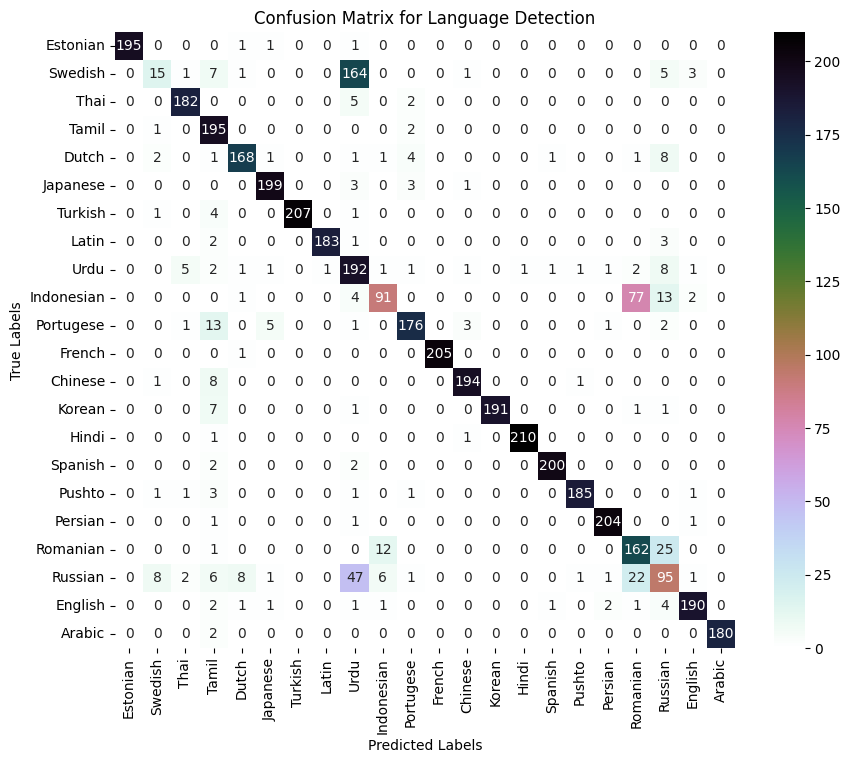

In [ ]:

# k-fold cross validation splitting method
kf_w2v_t = KFold(n_splits=5, shuffle=True, random_state=42)


vector_size = 100


for model_name, model in models.items():
    print(f"Model: {model_name}")

    fold_accuracies_w2v_t = []
    fold_confusion_matrices_w2v_t = []
    fold_classification_report_w2v_t = []

    # start Cross-Validation
    for fold, (train_index, test_index) in enumerate(kf_w2v_t.split(data_tokenize)):

        train_data_w2v_t = data_tokenize.iloc[train_index]
        test_data_w2v_t = data_tokenize.iloc[test_index]

        # training Word2Vec model on the training datas
        model_w2v_t = Word2Vec(sentences=train_data_w2v_t['tokens'], vector_size=100, window=5, min_count=1, workers=4)

        # convert training datas to vectors
        X_train_w2v_t = np.array([get_sentence_vector(model_w2v_t, tokens, vector_size) for tokens in train_data_w2v_t['tokens']])
        y_train_w2v_t = train_data_w2v_t['language']

        # convert test datas to vectors
        X_test_w2v_t = np.array([get_sentence_vector(model_w2v_t, tokens, vector_size) for tokens in test_data_w2v_t['tokens']])
        y_test_w2v_t = test_data_w2v_t['language']

        # training model
        model.fit(X_train_w2v_t, y_train_w2v_t)

        # predicting on test datas
        y_pred_w2v_t = model.predict(X_test_w2v_t)

        # calc accuracy
        accuracy_w2v_t = accuracy_score(y_test_w2v_t, y_pred_w2v_t)
        fold_accuracies_w2v_t.append(accuracy_w2v_t)

        # calc confusion matrix
        conf_matrix_w2v_t = confusion_matrix(y_test_w2v_t, y_pred_w2v_t)
        fold_confusion_matrices_w2v_t.append(conf_matrix_w2v_t)

        cl_report_w2v_t = classification_report(y_test_w2v_t, y_pred_w2v_t, zero_division=1)
        fold_classification_report_w2v_t.append(cl_report_w2v_t)

    # calc mean of accuracies of 5 folds
    print(fold_accuracies_w2v_t)
    mean_accuracy_w2v_t = np.mean(fold_accuracies_w2v_t)
    print(f"Mean Accuracy for {model_name}: {mean_accuracy_w2v_t:.4f}")

    # find the closest fold to the mean of accuracies
    closest_fold_w2v_t = np.argmin(np.abs(np.array(fold_accuracies_w2v_t) - mean_accuracy_w2v_t))
    print(f"Fold {closest_fold_w2v_t+1} is closest to the mean accuracy.")

    closest_cl_report_w2v_t = fold_classification_report_w2v_t[closest_fold_w2v_t]
    print(f"Classification Report for {model_name} (Fold {closest_fold_w2v_t+1}):\n{closest_cl_report_w2v_t}")

    # show confusion matrix for that fold
    closest_conf_matrix_w2v_t = fold_confusion_matrices_w2v_t[closest_fold_w2v_t]
    print(f"Confusion Matrix for {model_name} (Fold {closest_fold_w2v_t+1}):")

    plt.figure(figsize=(10, 8))
    sns.heatmap(closest_conf_matrix_w2v_t, annot=True, fmt='d', cmap='cubehelix_r', xticklabels=labels , yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Language Detection')
    plt.show()

## compare Word2Vec method with preprocessing and without preprocessing :

model name  |  with preprocessing  |  without preprocessing
------------|----------------------|-----------------------
Random Forest | 63.04              |  87.59
Logistic Regression | 49.65        |  89.09
Linear SVM | 50.11                 |  89.77
Gaussian SVM | 46.31               |  86.71



# original Bert model

In [ ]:
sentences = df['Text']
labels = df['language']
print(sentences)

0        klement gottwaldi surnukeha palsameeriti ning ...
1        sebes joseph pereira thomas  på eng the jesuit...
2        ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...
3        விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...
4        de spons behoort tot het geslacht haliclona en...
                               ...                        
21995    hors du terrain les années  et  sont des année...
21996    ใน พศ  หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...
21997    con motivo de la celebración del septuagésimoq...
21998    年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...
21999     aprilie sonda spațială messenger a nasa și-a ...
Name: Text, Length: 22000, dtype: object


In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

#print(encoded_labels)
#print(label_encoder.inverse_transform(encoded_labels))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(sentences, encoded_labels, test_size = .2, random_state = 42)
print('number of classes : ', len(set(y_train)))

number of classes :  22


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, max_length=128)

In [ ]:
test_encodings = tokenizer(list(x_test), truncation=True, padding=True, max_length=128)

In [ ]:
class LanguageDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# create pytorch dataset
train_dataset = LanguageDataset(train_encodings, y_train.tolist())
test_dataset = LanguageDataset(test_encodings, y_test.tolist())

In [ ]:
os.environ['WANDB_DISABLED'] = 'true'

In [ ]:
# loading BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train)))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='/home/shaghayegh',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model, # BERT model
    args=training_args, # settings abt training
    train_dataset=train_dataset, # training datas
    eval_dataset=test_dataset # test datas
)

In [ ]:
# training model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.106900,0.097245
2,0.051700,0.080281
3,0.035100,0.074604


TrainOutput(global_step=6600, training_loss=0.14582469470573195, metrics={'train_runtime': 1857.3601, 'train_samples_per_second': 28.427, 'train_steps_per_second': 3.553, 'total_flos': 3473689595904000.0, 'train_loss': 0.14582469470573195, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.07460396736860275, 'eval_runtime': 31.8677, 'eval_samples_per_second': 138.071, 'eval_steps_per_second': 17.259, 'epoch': 3.0}


In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)


In [ ]:
preds = np.argmax(predictions, axis=1)
print(preds)
y_preds = label_encoder.inverse_transform(preds)
print(y_preds)

[ 8 15 10 ...  3 13  2]
['Japanese' 'Russian' 'Latin' ... 'English' 'Pushto' 'Dutch']


In [ ]:
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy : {accuracy}')

Accuracy : 0.9886363636363636


In [ ]:
label_names = label_encoder.classes_


In [ ]:
print(label_names)

['Arabic' 'Chinese' 'Dutch' 'English' 'Estonian' 'French' 'Hindi'
 'Indonesian' 'Japanese' 'Korean' 'Latin' 'Persian' 'Portugese' 'Pushto'
 'Romanian' 'Russian' 'Spanish' 'Swedish' 'Tamil' 'Thai' 'Turkish' 'Urdu']


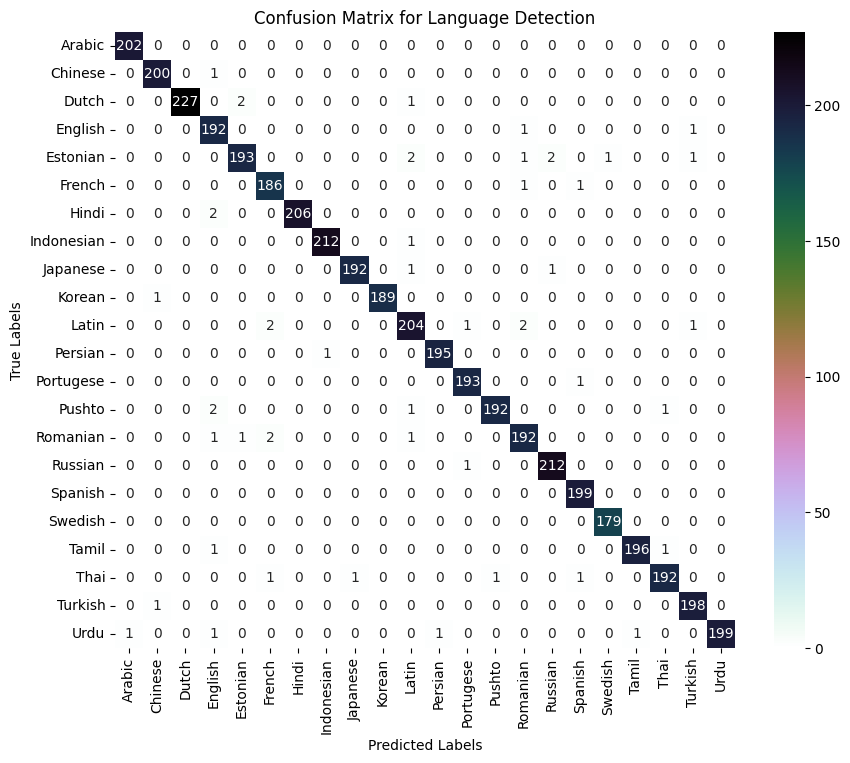

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cubehelix_r', xticklabels=label_names , yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Language Detection')
plt.show()